Import dependencies

In [2]:
from model.layers import GraphSpectralFilterLayer, AnalysisFilter
from model.spectral_filter import Graph
import torch
import torch.nn.functional as F
from torch import nn
from random import seed as rseed
from numpy.random import seed as nseed
from citation import get_dataset, random_planetoid_splits, run
from citation.train_eval import evaluate
import numpy as np


Define hyperparameters

In [3]:
dataset_name = 'Citeseer'

random_splits = False
runs = 1
epochs =400
alpha = 0.4325176513738335
seed =729
lr =0.0001502755734819816
weight_decay =9.70164175612743e-05
patience=100
hidden=83
heads =19
dropout=0.6760251172015357
normalize_features =True
pre_training = False
cuda = False
chebyshev_order =17
edge_dropout =0
node_feature_dropout =0
filter_name ='analysis'

rseed(seed)
nseed(seed)
torch.manual_seed(seed)

cuda = cuda and torch.cuda.is_available()

if cuda:
    torch.cuda.manual_seed(seed)
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    
def get_correctly_predicted_node_idx(net, key):
    net.eval()
    with torch.no_grad():
        logits  = net(dataset[0])[0]
    mask = dataset[0]['{}_mask'.format(key)]
    pred = logits[mask].max(1)[1]
    return { *pred.eq(dataset[0].y[mask]).nonzero().view(-1).tolist() }

In [4]:
def matching_labels_distribution(nodes_set):
    hop_1_matching_percent = []
    hop_2_matching_percent = []
    hop_3_matching_percent = []
    for n in nodes_set:
        hop_1_neighbours = list(nx.ego_graph(G, n.item(), 1).nodes())
        hop_2_neighbours = list(nx.ego_graph(G, n.item(), 2).nodes())
        hop_3_neighbours = list(nx.ego_graph(G, n.item(), 3).nodes())
        node_label = dataset[0].y[n]
        hop_1_labels = dataset[0].y[hop_1_neighbours]
        hop_2_labels = dataset[0].y[hop_2_neighbours]
        hop_3_labels = dataset[0].y[hop_3_neighbours]
        matching_1_labels = node_label == hop_1_labels
        matching_2_labels = node_label == hop_2_labels
        matching_3_labels = node_label == hop_3_labels
        hop_1_matching_percent.append(matching_1_labels.float().sum()/matching_1_labels.shape[0])
        hop_2_matching_percent.append(matching_2_labels.float().sum()/matching_2_labels.shape[0])
        hop_3_matching_percent.append(matching_3_labels.float().sum()/matching_3_labels.shape[0])


    print('matching labels in 1st hop:', torch.tensor(hop_1_matching_percent).mean())
    print('matching labels in 2st hop:', torch.tensor(hop_2_matching_percent).mean())
    print('matching labels in 3rd hop:', torch.tensor(hop_3_matching_percent).mean())
    plt.figure(figsize=(15,3))
    plt.subplot(1, 3, 1)
    plt.hist(hop_1_matching_percent, color = 'blue', edgecolor = 'black', bins = 10)
    plt.subplot(1, 3, 2)
    plt.hist(hop_2_matching_percent, color = 'blue', edgecolor = 'black', bins = 10)
    plt.subplot(1, 3, 3)
    plt.hist(hop_2_matching_percent, color = 'blue', edgecolor = 'black', bins = 10)


Define model

In [5]:
class Net(torch.nn.Module):
    def __init__(self, dataset):
        super(Net, self).__init__()
        data = dataset[0]
        adj = torch.sparse_coo_tensor(data.edge_index, torch.ones(data.num_edges))
        self.G = Graph(adj)
        self.G.estimate_lmax()

        self.analysis = GraphSpectralFilterLayer(self.G, dataset.num_node_features, hidden,
                                                 dropout=dropout, out_channels=heads, filter=filter_name,
                                                 pre_training=pre_training, device='cuda' if cuda else 'cpu',
                                                 alpha=alpha, chebyshev_order=chebyshev_order)
        # self.mlp = nn.Sequential(nn.Linear(hidden * heads, 128),
        #                             nn.ReLU(inplace=True),
        #                             nn.Linear(128, 64),
        #                             nn.ReLU(inplace=True),
        #                             nn.Linear(64, 32),
        #                             nn.ReLU(inplace=True),
        #                             nn.Linear(32, dataset.num_classes),
        #                             nn.ReLU(inplace=True))

        # self.W = torch.zeros(hidden * heads, dataset.num_classes)

        self.synthesis = GraphSpectralFilterLayer(self.G, hidden * heads, dataset.num_classes, filter=filter_name,
                                                  device='cuda' if cuda else 'cpu', dropout=dropout,
                                                  out_channels=1, alpha=alpha, pre_training=False,
                                                  chebyshev_order=chebyshev_order)

    def reset_parameters(self):
        self.analysis.reset_parameters()
        # torch.nn.init.xavier_uniform_(self.W.data, gain=1.414)
        # for layer in self.mlp:
        #     if hasattr(layer, 'reset_parameters'):
        #         layer.reset_parameters()
        self.synthesis.reset_parameters()

    def forward(self, data):
        x = data.x
        x = F.dropout(x, p=dropout, training=self.training)
        x, attentions_1 = self.analysis(x)
        x = F.dropout(x, p=dropout, training=self.training)
        x, attentions_2 = self.synthesis(x)
        x = F.elu(x)
        # x = F.elu(x.mm(self.W))
        # x = self.mlp(x)
        return F.log_softmax(x, dim=1), attentions_1, attentions_2


dataset = get_dataset(dataset_name, normalize_features, edge_dropout=edge_dropout,
                                node_feature_dropout=node_feature_dropout)
if cuda:
    dataset[0].to('cuda')

# permute_masks = random_planetoid_splits if random_splits else None
# run(dataset, Net(dataset), runs, epochs, lr, weight_decay,
#     early_stopping, permute_masks)

In [6]:
class SingleNet(torch.nn.Module):
    def __init__(self, dataset):
        super(SingleNet, self).__init__()
        data = dataset[0]
        adj = torch.sparse_coo_tensor(data.edge_index, torch.ones(data.num_edges))
        self.G = Graph(adj)
        self.G.estimate_lmax()

        self.analysis = GraphSpectralFilterLayer(self.G, dataset.num_node_features, hidden,
                                                 dropout=dropout, out_channels=heads, filter=filter_name,
                                                 pre_training=pre_training, device='cuda' if cuda else 'cpu',
                                                 alpha=alpha, chebyshev_order=chebyshev_order)

        self.W = torch.nn.Parameter(torch.zeros(hidden * heads, dataset.num_classes))

    def reset_parameters(self):
        self.analysis.reset_parameters()
        torch.nn.init.xavier_uniform_(self.W.data, gain=1.414)

    def forward(self, data):
        x = data.x
        x = F.dropout(x, p=dropout, training=self.training)
        x, attentions_1 = self.analysis(x)
        x = F.dropout(x, p=dropout, training=self.training)
        x = F.elu(x.mm(self.W))
        return F.log_softmax(x, dim=1), attentions_1, None

Load trained model and evaluate

In [12]:
model = Net(dataset)
model.load_state_dict(torch.load('./model/best_{}_gpu.pkl'.format(dataset_name),  map_location={'cuda:0': 'cpu'}))

# model = SingleNet(dataset)
# model.load_state_dict(torch.load('./model/best_{}_single_layer.pkl'.format(dataset_name)))

filter_kernel = model.analysis.filter_kernel

model_correct_indices = get_correctly_predicted_node_idx(model, 'test')
evaluate(model, dataset[0])

{'train_loss': 0.5448257923126221,
 'train_acc': 0.9480021893814997,
 'val_loss': 0.8635192513465881,
 'val_acc': 0.772,
 'test_loss': 0.8461115956306458,
 'test_acc': 0.799,
 'f1_score': 0.876765855124737}

Obtain attention weights in layer 1 and 2

In [13]:
with torch.no_grad():
    _, att1, att2 = model(dataset[0])
model_att1_sum = torch.stack(att1).sum(dim=0)

Build NetworkX Graph

In [14]:
import networkx as nx
from scipy.sparse import coo_matrix
import numpy as np

# Build graph
adj = coo_matrix(
    (np.ones(dataset[0].num_edges),
    (dataset[0].edge_index[0].numpy(), dataset[0].edge_index[1].numpy())),
    shape=(dataset[0].num_nodes, dataset[0].num_nodes))
G = nx.Graph(adj)


In [15]:
from matplotlib import pyplot as plt
def plot_filter_banks(idx=list(range(heads)), kernel=model.analysis.filter._kernel, ax=None, no_ticks=False):
    x = torch.linspace(0, 2, 100)
    if no_ticks:
        plt.xticks([])
        plt.yticks([])
    if not ax:
        plt.figure()
        plt.plot(x, kernel(x).detach()[:, idx])
        if len(idx) > 1:
            plt.legend(['filter {}'.format(i) for i in range(1, len(idx) + 1)])
        plt.show()
    else:
        ax.plot(x, kernel(x).detach()[:, idx])
        if len(idx) > 1:
            ax.legend(['filter {}'.format(i) for i in range(1, len(idx) + 1)])

Plot filterbanks in layer 1 and 2

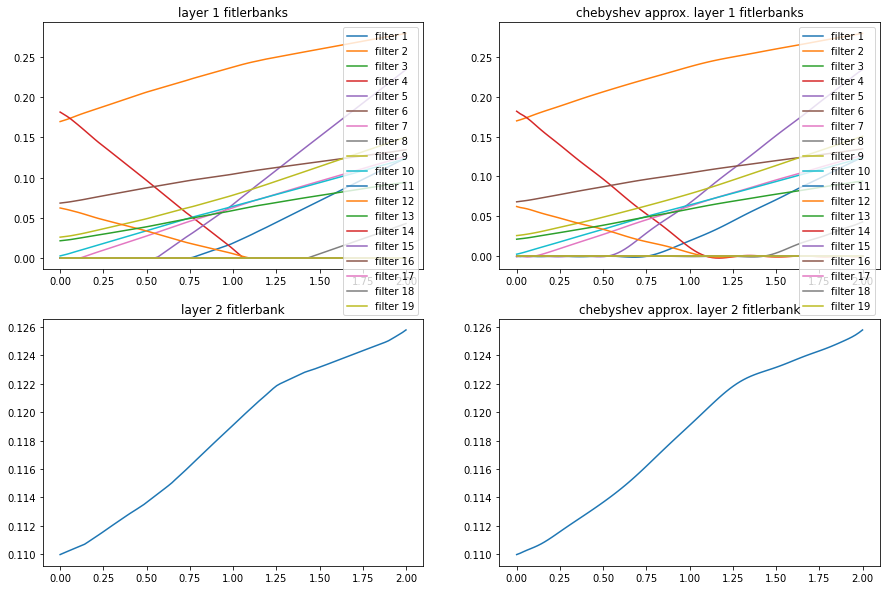

In [11]:
plt.figure(figsize=(15,10))
ax1 = plt.subplot(2, 2, 1)
ax1.set_title('layer 1 fitlerbanks')
plot_filter_banks(kernel=model.analysis.filter._kernel, ax=ax1)
ax2 = plt.subplot(2, 2, 2)
ax2.set_title('chebyshev approx. layer 1 fitlerbanks')
plot_filter_banks(kernel=model.analysis.filter.cheby_eval, ax=ax2)

if hasattr(model, 'synthesis'):
    ax3 = plt.subplot(2, 2, 3)
    ax3.set_title('layer 2 fitlerbank')
    plot_filter_banks(idx=[0], kernel=model.synthesis.filter._kernel, ax=ax3)
    ax4 = plt.subplot(2, 2, 4)
    ax4.set_title('chebyshev approx. layer 2 fitlerbank')
    plot_filter_banks(idx=[0], kernel=model.synthesis.filter.cheby_eval, ax=ax4)

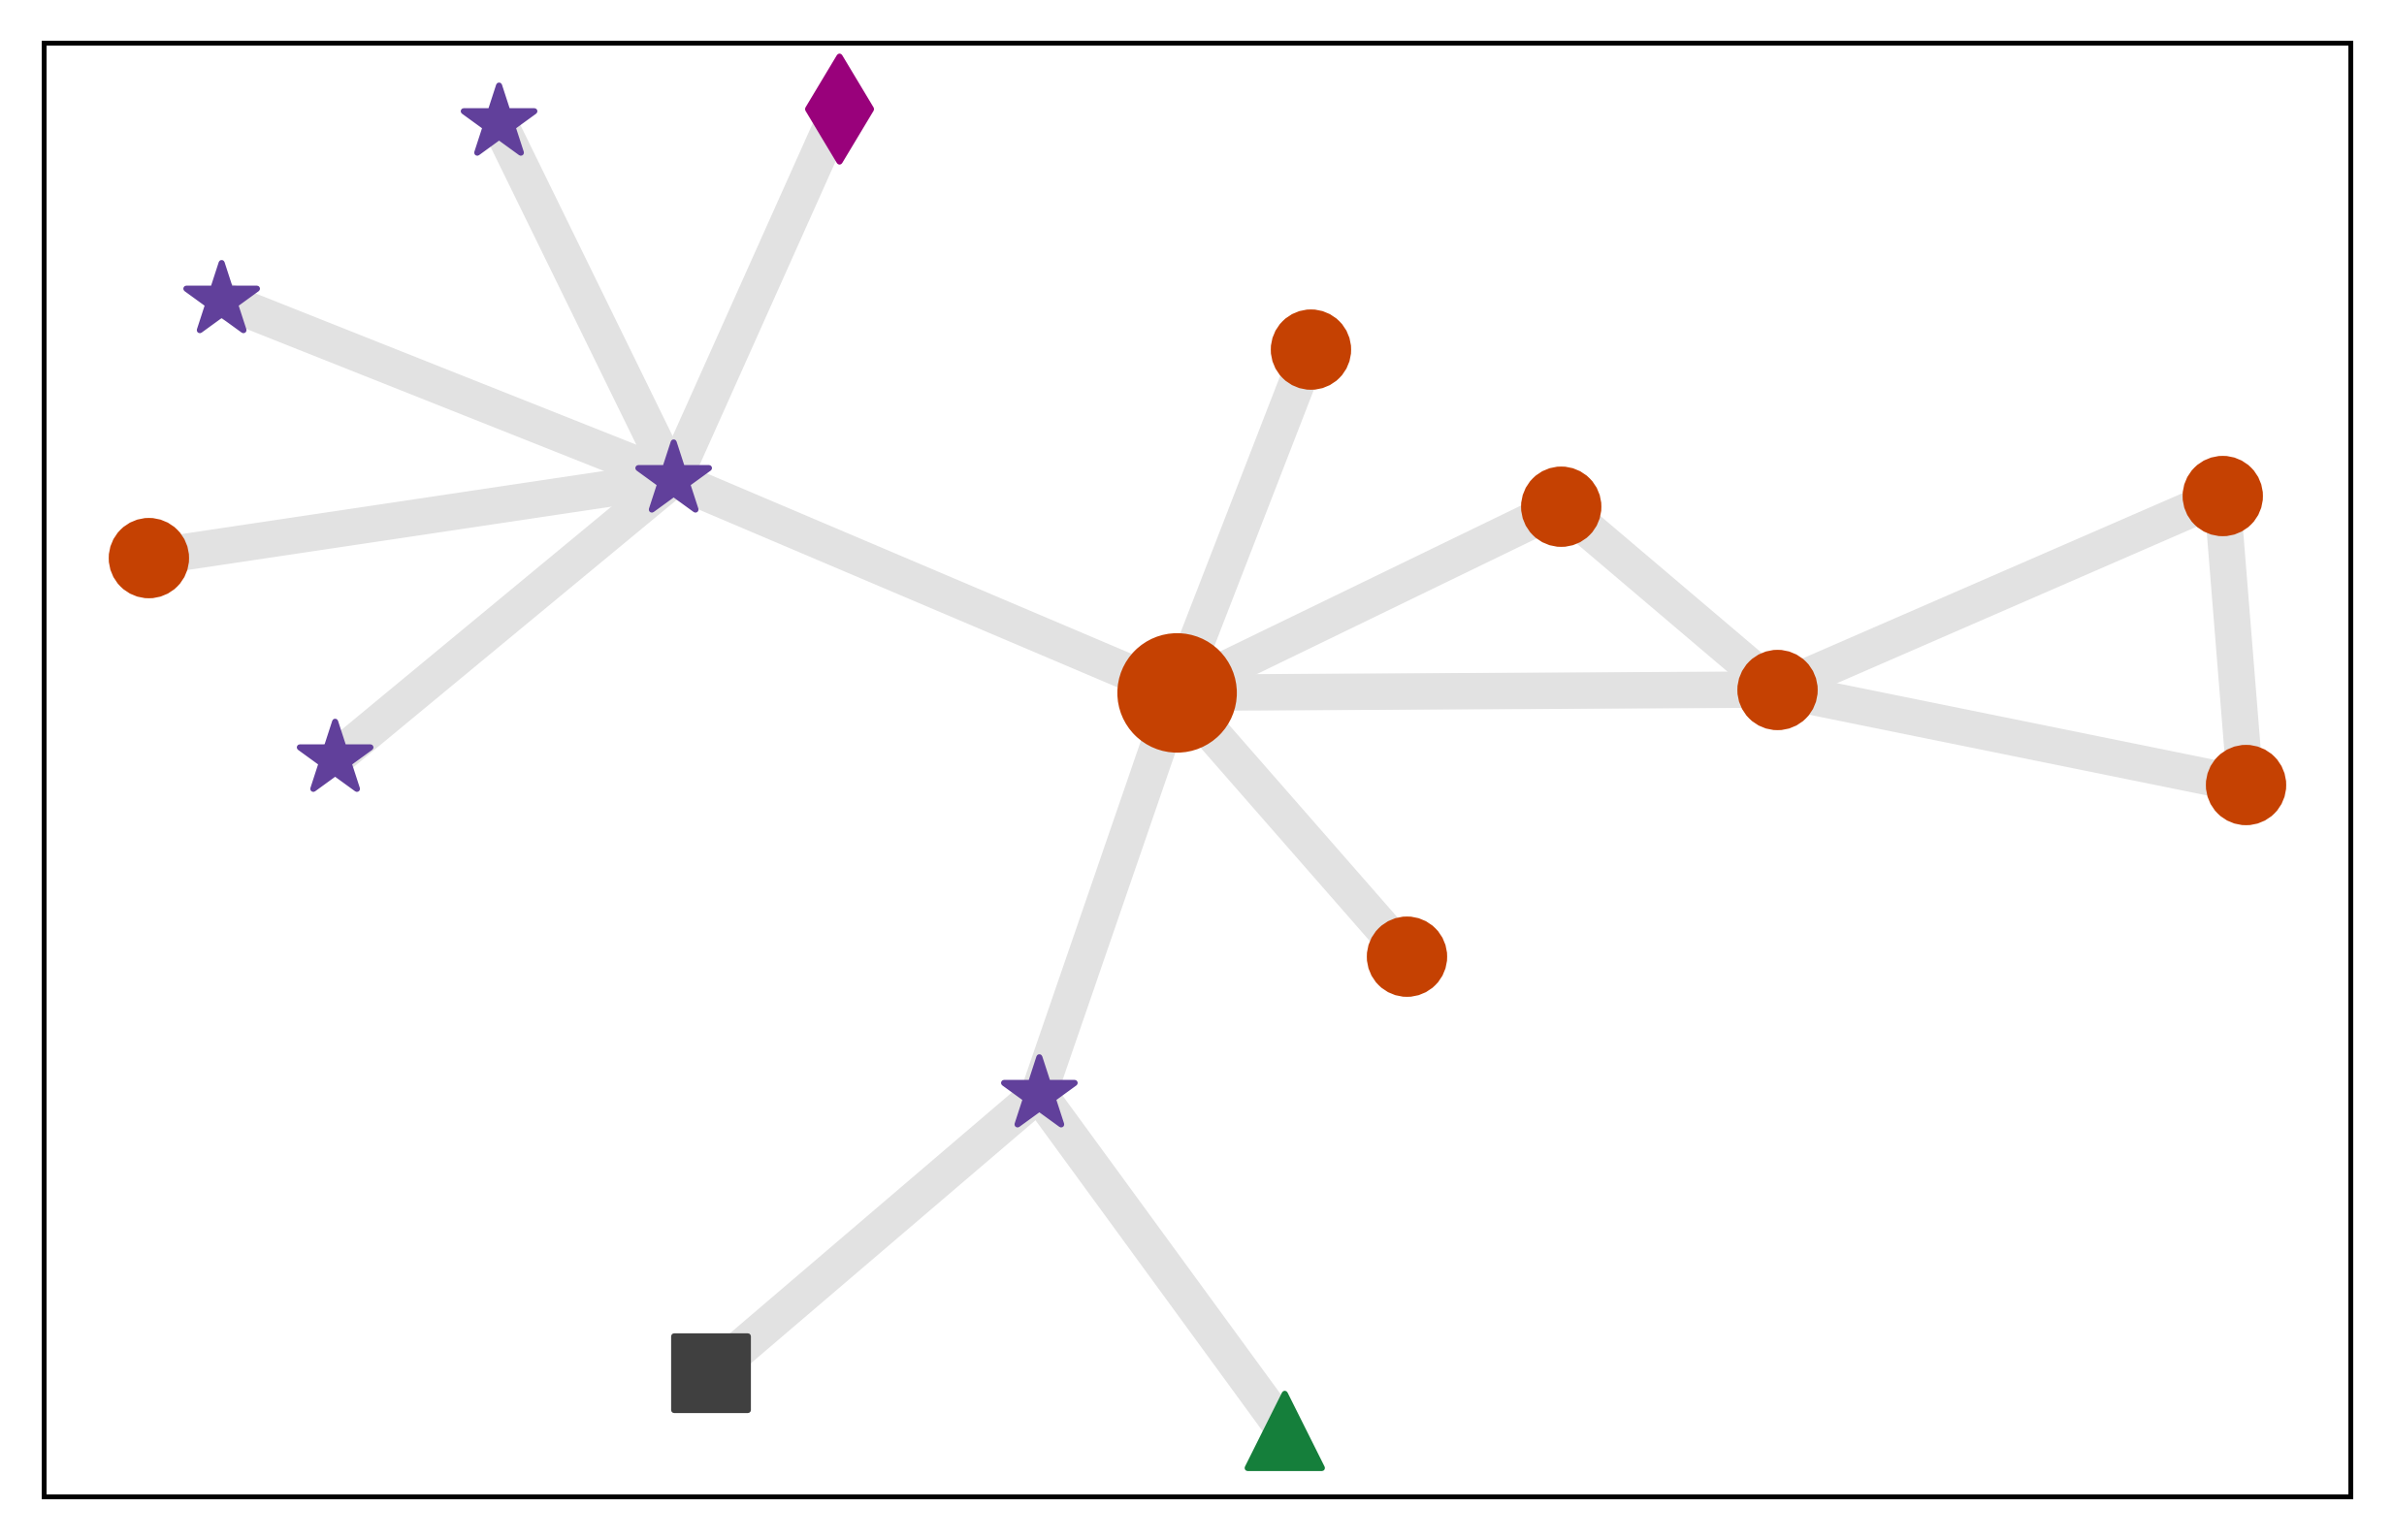

In [36]:
node = 269
# node = model_not_gat_correct_nodes[1].item()
Gego = nx.ego_graph(G, node, 2)
nodePos = nx.layout.kamada_kawai_layout(Gego)

node_colors = {
   0: plt.cm.Reds, 1: plt.cm.Oranges, 2: plt.cm.RdPu, 
   3: plt.cm.Greens, 4: plt.cm.Greys, 5: plt.cm.Purples, 
}
node_shapes={0: '8', 1: 'o', 2: 'd', 3: '^', 4: 's', 5: '*'}



plt.figure(figsize=(15,15), dpi=450);
# plt.figure(figsize=(15,15));

ax = plt.subplot(3, 2, 1)
                 

for n in Gego.nodes:
    nx.draw_networkx_nodes(Gego, nodePos,
                           nodelist=[n],
                           node_color=[node_colors[dataset[0].y[n].item()](0.8)],
                           node_shape=node_shapes[dataset[0].y[n].item()],
                           node_size=350 if n == node else 150,
                           ax=ax)
nx.draw_networkx_edges(Gego, nodePos,
#                            edgelist=[*[(node, n) for n in nodes], ],
                           edgelist= Gego.edges,
#                            width=[5 if e in edges else 2 for e in Gego.edges],
                           width=6,
#                            edge_color=[plt.cm.Greys(0.8) if e in edges else plt.cm.Greys(0.2) for e in Gego.edges],
                           edge_color=plt.cm.Greys(0.2),
                           ax=ax)

# for j in G.nodes:
#     a = None
#     for i in range(len(att1)):
#     #     plt.figure(figsize=(15,5), dpi=450)
# #         plt.figure(figsize=(15,5));

#         att = att1[i]
#         if a is None and len((att[j] > 0.001).nonzero().view(-1).tolist()) != 1:
#             a = len((att[j] > 0.0001).nonzero().view(-1).tolist())
#         else:
#             if a is not None and np.abs(a - len((att[j] > 0.001).nonzero().view(-1).tolist())) > 3 and len((att[j] > 0.001).nonzero().view(-1).tolist()) != 1:
#                 if nx.single_source_shortest_path_length(G, j) > 1:
#                     print(j)
#                     print(i, a, len((att[j] > 0.001).nonzero().view(-1).tolist()))


3 6


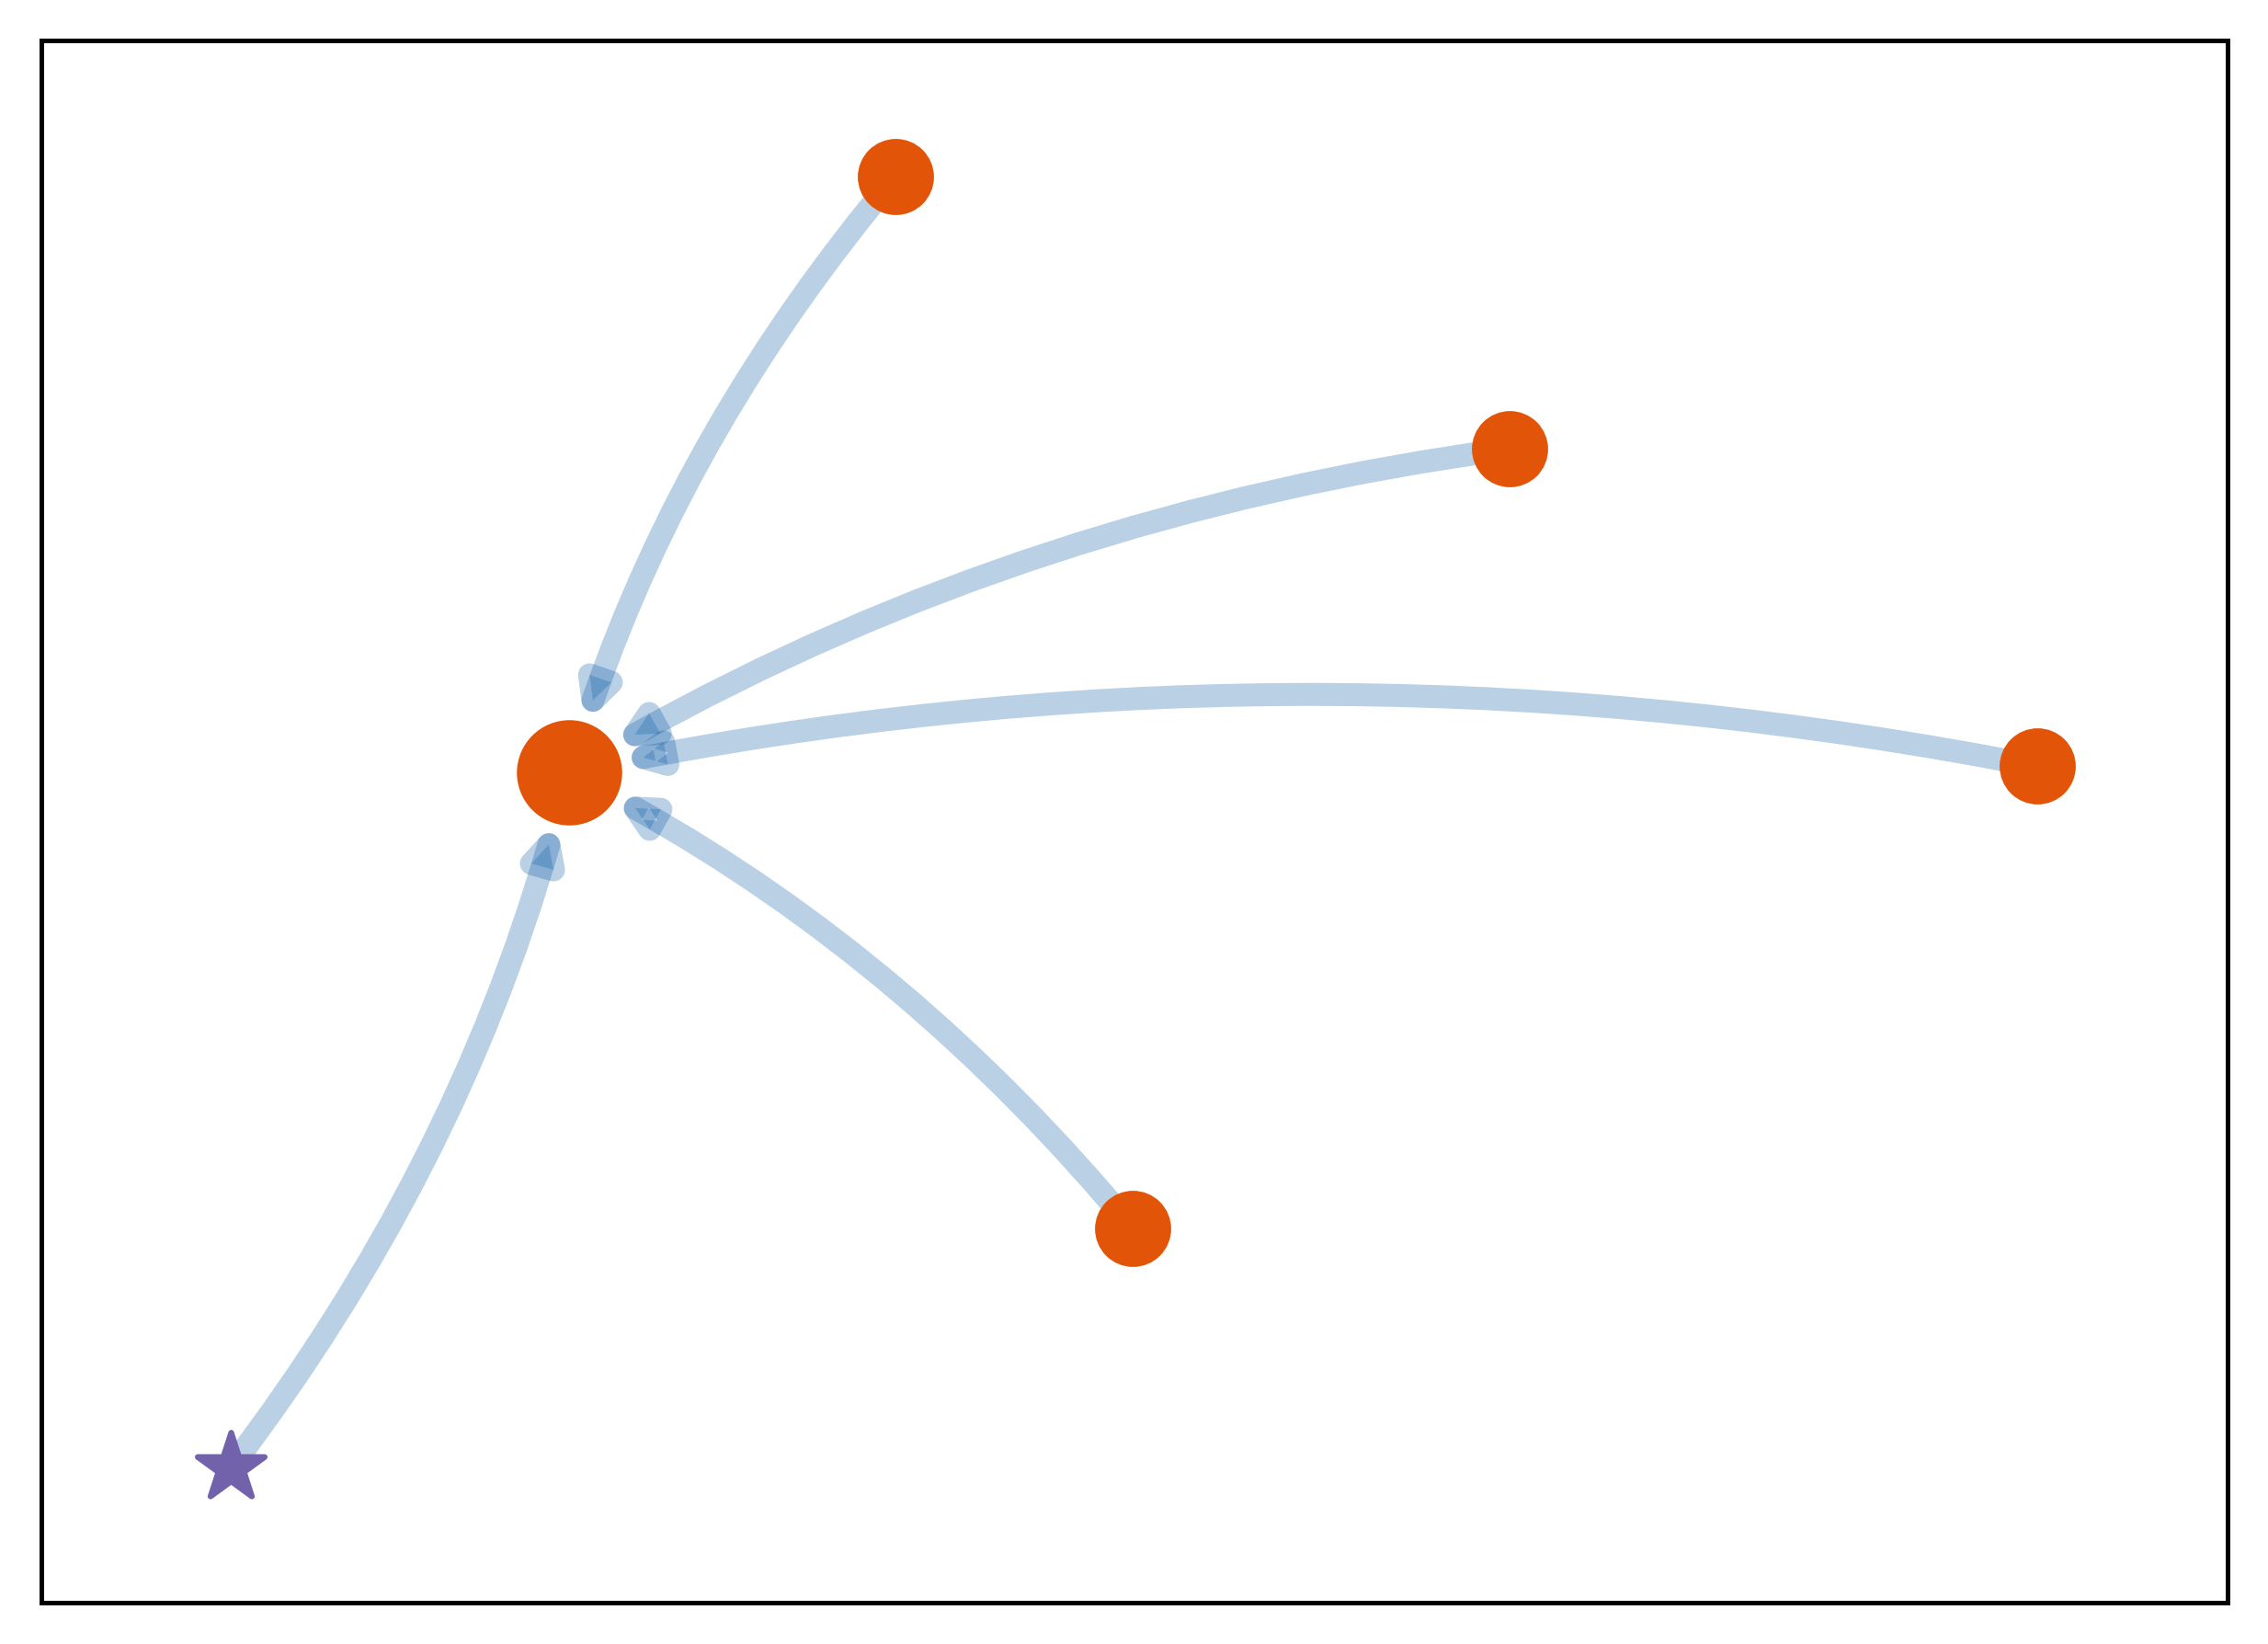

In [37]:

# node=269
# # node=4
# # node = model_not_gat_correct_nodes[1].item()
Gego = nx.ego_graph(G, node, 2)
# nodePos = nx.layout.kamada_kawai_layout(Gego)
node_colors = {
   0: plt.cm.Reds, 1: plt.cm.Oranges, 2: plt.cm.RdPu, 
   3: plt.cm.Greens, 4: plt.cm.Greys, 5: plt.cm.Purples, 
}
node_shapes={0: '8', 1: 'o', 2: 'd', 3: '^', 4: 's', 5: '*'}



# for n in Gego.nodes:
#     nx.draw_networkx_nodes(Gego, nodePos,
#                            nodelist=[n],
#                            node_color=[node_colors[dataset[0].y[n].item()](0.8)],
#                            node_shape="*" if n == node else node_shapes[dataset[0].y[n].item()],
#                            node_size=350 if n == node else 80)
# nx.draw_networkx_edges(Gego,nodePos, width=2, alpha=0.4)
# for i in range(heads):
# for i in [0, 2, 3, 10]:
for i in [3]:
    Gego = nx.ego_graph(G, node, 2)
    att = att1[i]
    nodes = (att[node] > 0.001).nonzero().view(-1).tolist()
    print(i, len(nodes))
    plt.figure(figsize=(15,5), dpi=450);
#     ax = plt.subplot(1, 2, 1)
#     plot_filter_banks(idx=[i], ax=ax, no_ticks=True)

    ax = plt.subplot(1, 2, 2)
#     for n in Gego.nodes:
    for n in nodes:
        nx.draw_networkx_nodes(Gego, nodePos,
                               nodelist=[n],
                               ax=ax,
                               node_color=[node_colors[dataset[0].y[n].item()](0.7)],
                               node_shape=node_shapes[dataset[0].y[n].item()],
                               node_size=300 if n == node else 150,
#                                node_size=300 if n == node else (torch.exp(att[node, n])*100).clamp(max=300, min=50),
#                                node_size=300 if n == node else 200
                              )
#     edges = list(filter(lambda e: e[0] in nodes and e[1] in nodes, list(Gego.edges)))
#     nx.draw_networkx_edges(Gego, nodePos,
# #                            edgelist=[*[(node, n) for n in nodes], ],
#                            edgelist= Gego.edges,
# #                            width=[5 if e in edges else 2 for e in Gego.edges],
#                            width=7,
# #                            edge_color=[plt.cm.Greys(0.8) if e in edges else plt.cm.Greys(0.2) for e in Gego.edges],
#                            edge_color=plt.cm.Greys(0.2),
#                            alpha=0.4,
#                            ax=ax)
#     nx.draw_networkx_edges(Gego, nodePos,
#                            edgelist=[*[(n, node) for n in nodes], ],
# #                            edgelist= Gego.edges,
# #                            width=[5 if e in edges else 2 for e in Gego.edges],
#                            width=1.5,
#                            style="dashed",
# #                            edge_color=[plt.cm.Greys(0.8) if e in edges else plt.cm.Greys(0.2) for e in Gego.edges],
# #                            alpha=0.5,
#                            edge_color=plt.cm.Greys(0.4),
#                            arrows=True,
#                            ax=ax)
    Gego = nx.DiGraph(Gego)
    nx.draw_networkx_edges(Gego, nodePos,
                           edgelist=[*[(n, node) for n in nodes], ],
#                            edgelist= Gego.edges,
#                            width=[5 if e in edges else 2 for e in Gego.edges],
                           width=4,
#                            edge_color=[plt.cm.Greys(0.8) if e in edges else plt.cm.Greys(0.2) for e in Gego.edges],
                           alpha=0.3,
                           edge_color=plt.cm.Blues(0.8),
                           connectionstyle='arc3,rad=0.1',
                           arrows=True,
                           ax=ax)
    plt.show();


### Frequency cutoff analysis

In [16]:
# Cut frequency bands abruptly
class CutOff(nn.Module):
    def __init__(self, kernel, min_val = 0, max_val = 2):
        super(CutOff, self).__init__()
        self.min = min_val
        self.max = max_val
        self.kernel = kernel

    def reset_parameters(self):
        pass

    def forward(self, x):
        h = torch.where(x.view(-1,1).repeat(1, heads) < self.min, torch.zeros(x.shape[0], heads), self.kernel(x))
        h = torch.where(x.view(-1,1).repeat(1, heads) > self.max, torch.zeros(x.shape[0], heads), h)
        return h

Evaluate low pass cutoff

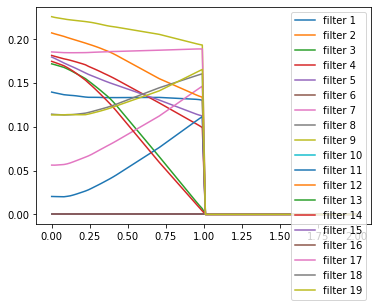

{'train_loss': 0.6151728630065918, 'train_acc': 0.8856048166392994, 'val_loss': 0.837712824344635, 'val_acc': 0.792, 'test_loss': 0.8248162865638733, 'test_acc': 0.808, 'f1_score': 0.8482116020438834}


In [61]:
threshold = 1
model.analysis.filter_kernel = CutOff(max_val=threshold, kernel=filter_kernel)
model.analysis.filter._kernel = CutOff(max_val=threshold, kernel=filter_kernel)
plot_filter_banks(kernel=model.analysis.filter_kernel)
print(evaluate(model, dataset[0]))

low_pass_correct_indices = get_correctly_predicted_node_idx(model, 'test')
with torch.no_grad():
    _, low_att1, low_att2 = model(dataset[0])

Evaluate high pass cutoff

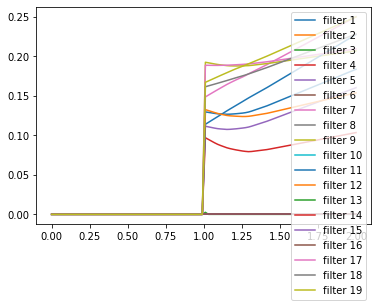

{'train_loss': 1.5150789022445679, 'train_acc': 0.4745484400656814, 'val_loss': 1.5173028707504272, 'val_acc': 0.456, 'test_loss': 1.548227071762085, 'test_acc': 0.456, 'f1_score': 0.4661857529305681}


In [62]:
threshold = 1
model.analysis.filter_kernel = CutOff(min_val=threshold, kernel=filter_kernel)
model.analysis.filter._kernel = CutOff(min_val=threshold, kernel=filter_kernel)
plot_filter_banks(kernel=model.analysis.filter_kernel)
print(evaluate(model, dataset[0]))

high_pass_correct_indices = get_correctly_predicted_node_idx(model, 'test')

with torch.no_grad():
    _, high_att1, high_att2 = model(dataset[0])

Evaluate band pass cutoff

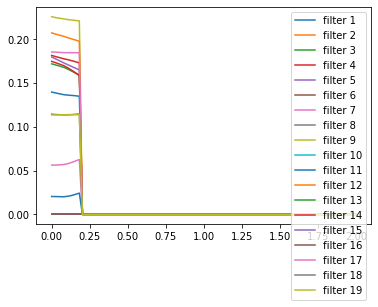

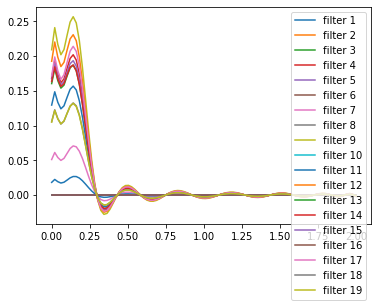

{'train_loss': 0.7330939769744873, 'train_acc': 0.8100711548987412, 'val_loss': 0.8488997220993042, 'val_acc': 0.78, 'test_loss': 0.8447385430335999, 'test_acc': 0.783, 'f1_score': 0.7974150886684701}


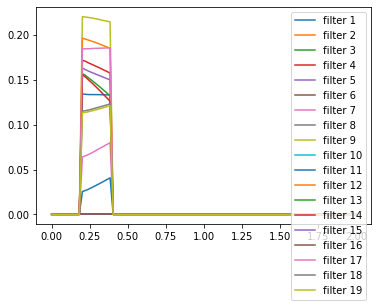

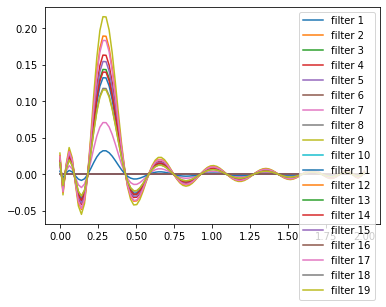

{'train_loss': 0.6519625186920166, 'train_acc': 0.8604269293924466, 'val_loss': 0.829319417476654, 'val_acc': 0.792, 'test_loss': 0.8177111744880676, 'test_acc': 0.796, 'f1_score': 0.8307784791103096}


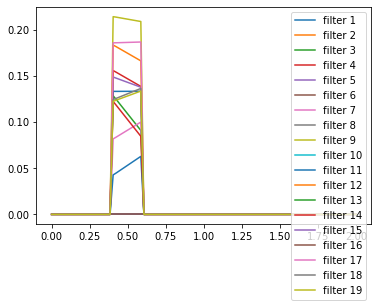

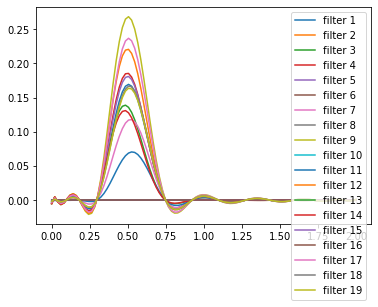

{'train_loss': 0.7028283476829529, 'train_acc': 0.8275862068965517, 'val_loss': 0.8408917784690857, 'val_acc': 0.778, 'test_loss': 0.8357565402984619, 'test_acc': 0.785, 'f1_score': 0.8073339344755035}


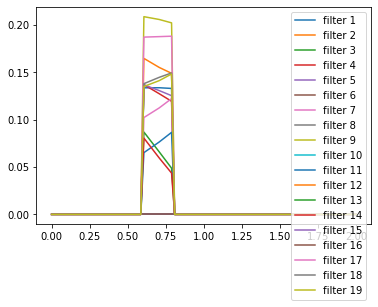

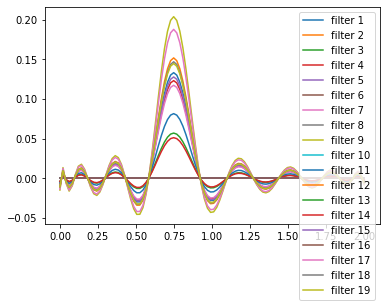

{'train_loss': 0.7656554579734802, 'train_acc': 0.8018609742747673, 'val_loss': 0.8583044409751892, 'val_acc': 0.772, 'test_loss': 0.8571382761001587, 'test_acc': 0.775, 'f1_score': 0.7892996693718064}


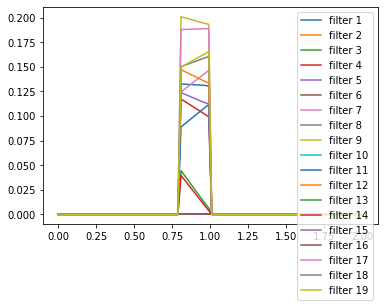

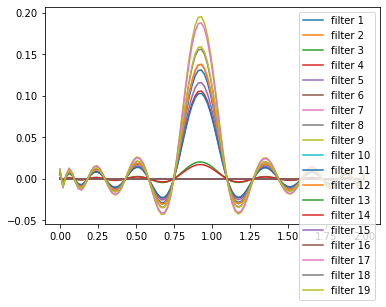

{'train_loss': 0.5773971676826477, 'train_acc': 0.9173508483853311, 'val_loss': 0.8524738550186157, 'val_acc': 0.784, 'test_loss': 0.8331161737442017, 'test_acc': 0.804, 'f1_score': 0.8632401562969643}


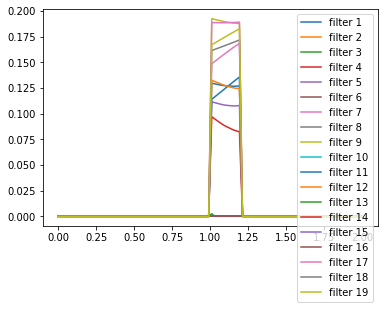

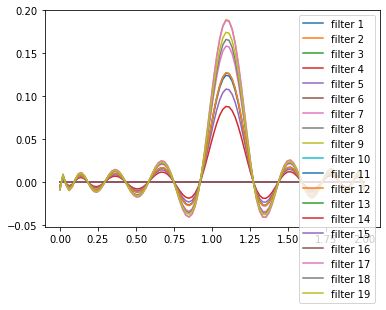

{'train_loss': 0.9624601006507874, 'train_acc': 0.8040503557744937, 'val_loss': 1.1317627429962158, 'val_acc': 0.684, 'test_loss': 1.1199127435684204, 'test_acc': 0.711, 'f1_score': 0.7580402765253983}


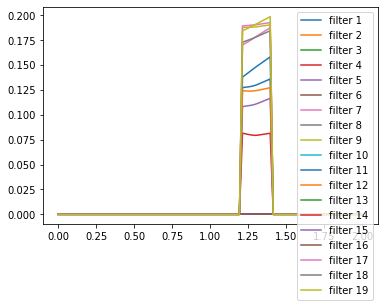

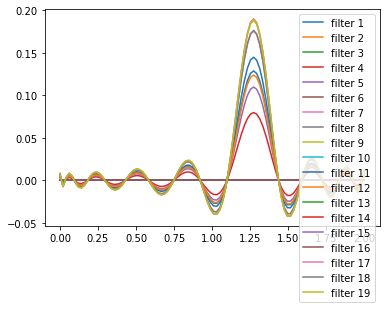

{'train_loss': 1.7917492389678955, 'train_acc': 0.16091954022988506, 'val_loss': 1.7917522192001343, 'val_acc': 0.138, 'test_loss': 1.7917500734329224, 'test_acc': 0.16, 'f1_score': 0.15719867748722574}


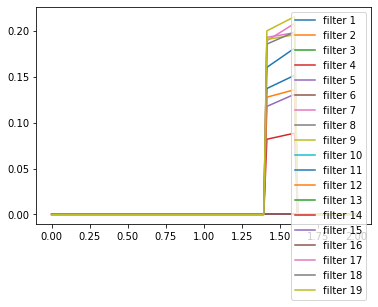

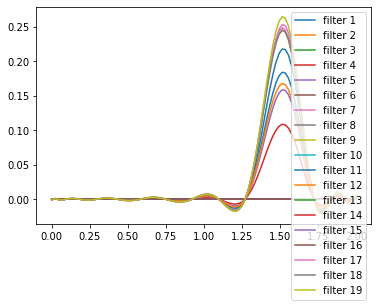

{'train_loss': 1.6928783655166626, 'train_acc': 0.2895457033388068, 'val_loss': 1.687770962715149, 'val_acc': 0.268, 'test_loss': 1.7157877683639526, 'test_acc': 0.273, 'f1_score': 0.2813345356176736}


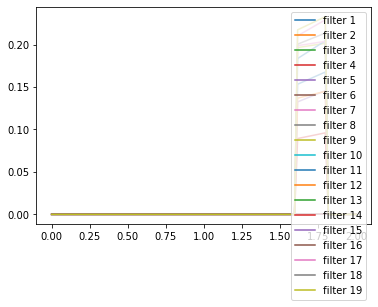

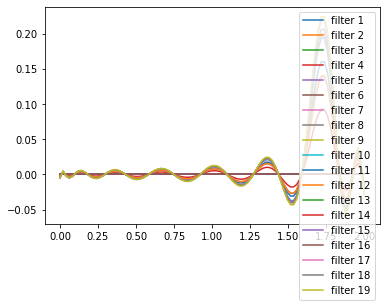

{'train_loss': 0.648838460445404, 'train_acc': 0.9474548440065681, 'val_loss': 0.9655167460441589, 'val_acc': 0.762, 'test_loss': 0.9460077881813049, 'test_acc': 0.783, 'f1_score': 0.8701532912533814}


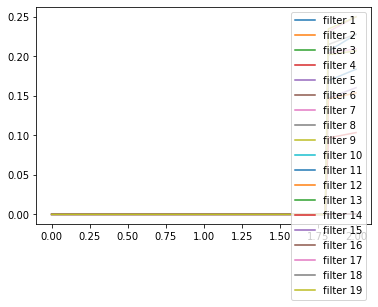

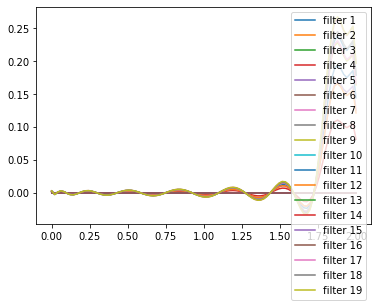

{'train_loss': 1.7917492389678955, 'train_acc': 0.16091954022988506, 'val_loss': 1.7917522192001343, 'val_acc': 0.138, 'test_loss': 1.7917500734329224, 'test_acc': 0.16, 'f1_score': 0.15719867748722574}


In [22]:
step = 0.2
for threshold in torch.arange(0, 2, step):
    model.analysis.filter_kernel = CutOff(min_val=threshold, max_val=threshold+step, kernel=filter_kernel)
    model.analysis.filter._kernel = CutOff(min_val=threshold,max_val=threshold+step, kernel=filter_kernel)
    plot_filter_banks(kernel=model.analysis.filter_kernel)
    plot_filter_banks(kernel=model.analysis.filter.cheby_eval)
    print(evaluate(model, dataset[0]))

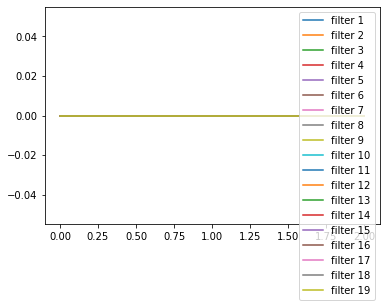

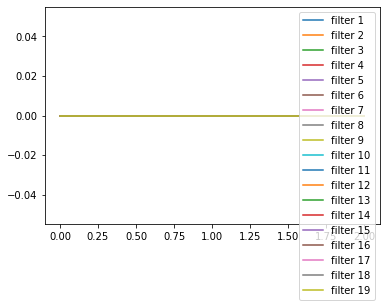

{'train_loss': 1.7917492389678955, 'train_acc': 0.16091954022988506, 'val_loss': 1.7917522192001343, 'val_acc': 0.138, 'test_loss': 1.7917500734329224, 'test_acc': 0.16, 'f1_score': 0.15719867748722574}


In [23]:
model.analysis.filter_kernel = CutOff(min_val=2, max_val=0, kernel=filter_kernel)
model.analysis.filter._kernel = CutOff(min_val=2, max_val=0, kernel=filter_kernel)

plot_filter_banks(kernel=model.analysis.filter_kernel)
plot_filter_banks(kernel=model.analysis.filter.cheby_eval)
print(evaluate(model, dataset[0]))

#### Frequency analysis on cutoff

In [63]:
low_not_high_correct_nodes = dataset[0]['test_mask'].nonzero().view(-1)[list(low_pass_correct_indices.difference(high_pass_correct_indices))]
high_not_low_correct_nodes = dataset[0]['test_mask'].nonzero().view(-1)[list(high_pass_correct_indices.difference(low_pass_correct_indices))]
high_and_low_correct_nodes = dataset[0]['test_mask'].nonzero().view(-1)[list(high_pass_correct_indices.intersection(low_pass_correct_indices))]
low_correct_nodes = dataset[0]['test_mask'].nonzero().view(-1)[list(low_pass_correct_indices)]
high_correct_nodes = dataset[0]['test_mask'].nonzero().view(-1)[list(high_pass_correct_indices)]


print('Number of node classified correctly by low-pass filters:', len(low_correct_nodes))
print('Number of node classified correctly by high-pass filters:', len(high_correct_nodes))
print('Number of node classified correctly by low-pass filters but not by high-pass filters:', len(low_not_high_correct_nodes))
print('Number of node classified correctly by high-pass filters but not by low-pass filters:', len(high_not_low_correct_nodes))
print('Number of node classified correctly by both high-pass and low-pass filters:', len(high_and_low_correct_nodes))

Number of node classified correctly by low-pass filters: 808
Number of node classified correctly by high-pass filters: 456
Number of node classified correctly by low-pass filters but not by high-pass filters: 380
Number of node classified correctly by high-pass filters but not by low-pass filters: 28
Number of node classified correctly by both high-pass and low-pass filters: 428


Neighbour distribution of nodes classified correct by high-pass

matching labels in 1st hop: tensor(0.8882)
matching labels in 2st hop: tensor(0.8213)
matching labels in 3rd hop: tensor(0.7657)


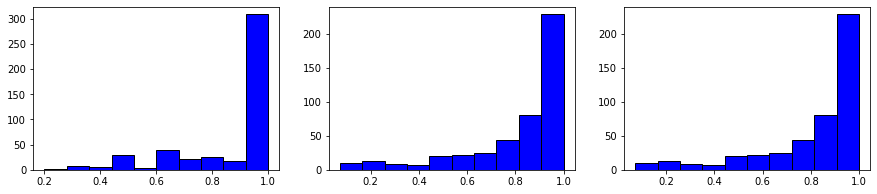

In [69]:
matching_labels_distribution(high_correct_nodes)

Neighbour distribution of nodes classified correct by low-pass

matching labels in 1st hop: tensor(0.9011)
matching labels in 2st hop: tensor(0.8426)
matching labels in 3rd hop: tensor(0.7954)


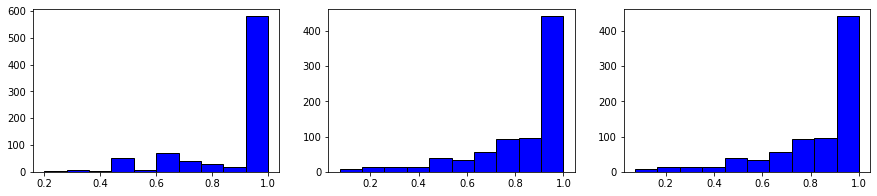

In [70]:
matching_labels_distribution(low_correct_nodes)

Neighbour distribution of nodes classified correct by high-pass but not low pass

matching labels in 1st hop: tensor(0.4921)
matching labels in 2st hop: tensor(0.3757)
matching labels in 3rd hop: tensor(0.3391)


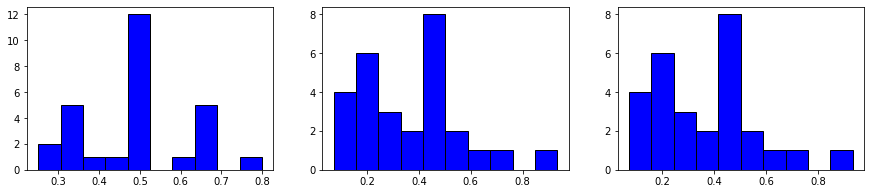

In [71]:
matching_labels_distribution(high_not_low_correct_nodes)

matching labels in 1st hop: tensor(0.8863)
matching labels in 2st hop: tensor(0.8339)
matching labels in 3rd hop: tensor(0.7974)


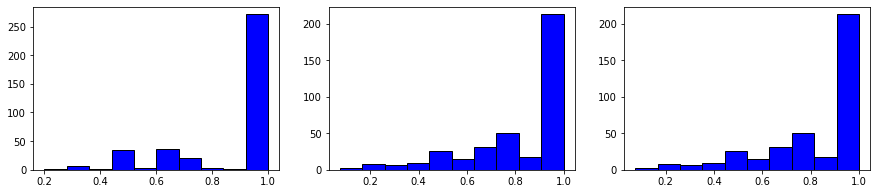

In [72]:
matching_labels_distribution(low_not_high_correct_nodes)

matching labels in 1st hop: tensor(0.9141)
matching labels in 2st hop: tensor(0.8504)
matching labels in 3rd hop: tensor(0.7936)


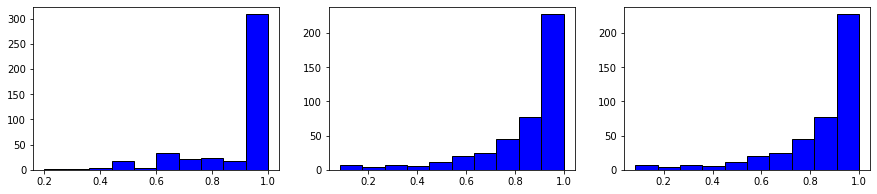

In [73]:
matching_labels_distribution(high_and_low_correct_nodes)

Draw attentions from high-pass filterbank(s)

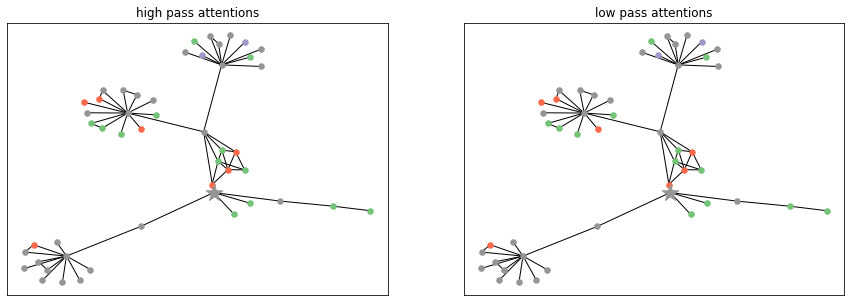

In [74]:
low_attentions = torch.stack(low_att1, 0).sum(0)
high_attentions = torch.stack(high_att1, 0).sum(0)

index = 7
node = high_not_low_correct_nodes[index].item()
# node = low_not_high_correct_nodes[2].item()
900411171521

Gego = nx.ego_graph(G, node, 3)
nodePos = nx.layout.spring_layout(Gego)

plt.figure(figsize=(15,5))
ax1 = plt.subplot(1, 2, 1)
ax1.set_title('high pass attentions')

for n in Gego.nodes:
    nx.draw_networkx_nodes(Gego, nodePos,
                           ax=ax1,
                           nodelist=[n],
                           node_color=[node_colors[dataset[0].y[n].item()](0.5)],
                           node_shape="*" if n == node else "o",
                           node_size=300 if n == node else (high_attentions[node, n]*50).clamp(max=400, min=30))
nx.draw_networkx_edges(Gego,nodePos, linewidths=0.5, ax=ax1)

ax2 = plt.subplot(1, 2, 2)
ax2.set_title('low pass attentions')

for n in Gego.nodes:
    nx.draw_networkx_nodes(Gego, nodePos,
                           ax=ax2,
                           nodelist=[n],
                           node_color=[node_colors[dataset[0].y[n].item()](0.5)],
                           node_shape="*" if n == node else "o",
                           node_size=300 if n == node else (low_attentions[node, n]*50).clamp(max=400, min=30))
nx.draw_networkx_edges(Gego,nodePos, linewidths=0.5, ax=ax2)

plt.show()

Attended node centrality distribution by frequency bands

In [49]:
# compute all node's centrality
centrality_between = nx.betweenness_centrality(G)
centrality_degree = nx.degree_centrality(G)
centrality_close = nx.closeness_centrality(G)
centrality_eigen = nx.eigenvector_centrality(G)

Degree centrality
high-pass centrality mean: 0.0010426989756524563, std: 0.0011824022512882948
low-pass centrality mean: 0.0018752984469756484, std: 0.002668846631422639

Betweeness centrality
high-pass centrality mean: 0.0012441986473277211, std: 0.003936524502933025
low-pass centrality mean: 0.003282387275248766, std: 0.008437315002083778

Closeness centrality
high-pass centrality mean: 0.06929505616426468, std: 0.024580800905823708
low-pass centrality mean: 0.07402349263429642, std: 0.02462601102888584

Eigen centrality
high-pass centrality mean: 0.009852447547018528, std: 0.026006149128079414
low-pass centrality mean: 0.02470412850379944, std: 0.0491228811442852


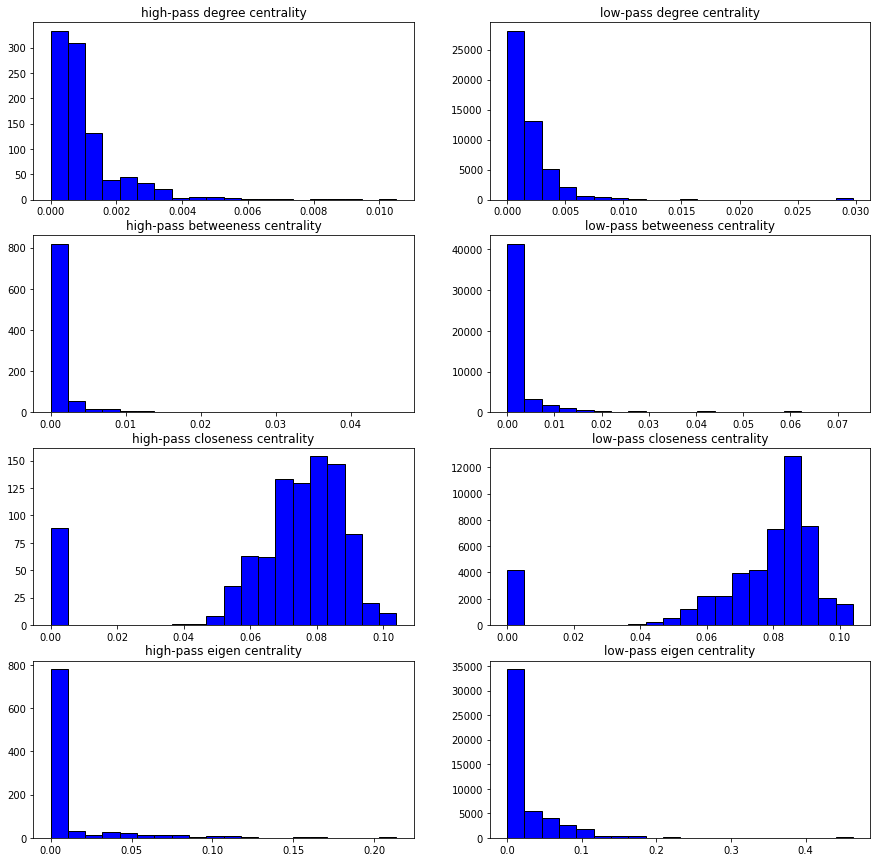

In [75]:
min_att = 0
plt.figure(figsize=(15,15))

print('Degree centrality')
ax1 = plt.subplot(4, 2, 1)
ax1.set_title('high-pass degree centrality')
centralities = torch.tensor([centrality_degree[n] for n in (high_attentions > min_att).nonzero(as_tuple=True)[1].tolist()])
print('high-pass centrality mean: {}, std: {}'.format(centralities.mean().item(), centralities.std().item()))
plt.hist(centralities, color = 'blue', edgecolor = 'black', bins = 20)

ax2 = plt.subplot(4, 2, 2)
ax2.set_title('low-pass degree centrality')
centralities = torch.tensor([centrality_degree[n] for n in (low_attentions > min_att).nonzero(as_tuple=True)[1].tolist()])
print('low-pass centrality mean: {}, std: {}'.format(centralities.mean().item(), centralities.std().item()))
plt.hist(centralities, color = 'blue', edgecolor = 'black', bins = 20)

print('\nBetweeness centrality')
ax3 = plt.subplot(4, 2, 3)
ax3.set_title('high-pass betweeness centrality')
centralities = torch.tensor([centrality_between[n] for n in (high_attentions > min_att).nonzero(as_tuple=True)[1].tolist()])
print('high-pass centrality mean: {}, std: {}'.format(centralities.mean().item(), centralities.std().item()))
plt.hist(centralities, color = 'blue', edgecolor = 'black', bins = 20)

ax4 = plt.subplot(4, 2, 4)
ax4.set_title('low-pass betweeness centrality')
centralities = torch.tensor([centrality_between[n] for n in (low_attentions > min_att).nonzero(as_tuple=True)[1].tolist()])
print('low-pass centrality mean: {}, std: {}'.format(centralities.mean().item(), centralities.std().item()))
plt.hist(centralities, color = 'blue', edgecolor = 'black', bins = 20)

print('\nCloseness centrality')
ax5 = plt.subplot(4, 2, 5)
ax5.set_title('high-pass closeness centrality')
centralities = torch.tensor([centrality_close[n] for n in (high_attentions > min_att).nonzero(as_tuple=True)[1].tolist()])
print('high-pass centrality mean: {}, std: {}'.format(centralities.mean().item(), centralities.std().item()))
plt.hist(centralities, color = 'blue', edgecolor = 'black', bins = 20)

ax6 = plt.subplot(4, 2, 6)
ax6.set_title('low-pass closeness centrality')
centralities = torch.tensor([centrality_close[n] for n in (low_attentions > min_att).nonzero(as_tuple=True)[1].tolist()])
print('low-pass centrality mean: {}, std: {}'.format(centralities.mean().item(), centralities.std().item()))
plt.hist(centralities, color = 'blue', edgecolor = 'black', bins = 20)

print('\nEigen centrality')
ax7 = plt.subplot(4, 2, 7)
ax7.set_title('high-pass eigen centrality')
centralities = torch.tensor([centrality_eigen[n] for n in (high_attentions > min_att).nonzero(as_tuple=True)[1].tolist()])
print('high-pass centrality mean: {}, std: {}'.format(centralities.mean().item(), centralities.std().item()))
plt.hist(centralities, color = 'blue', edgecolor = 'black', bins = 20)


ax8 = plt.subplot(4, 2, 8)
ax8.set_title('low-pass eigen centrality')
centralities = torch.tensor([centrality_eigen[n] for n in (low_attentions > min_att).nonzero(as_tuple=True)[1].tolist()])
print('low-pass centrality mean: {}, std: {}'.format(centralities.mean().item(), centralities.std().item()))
plt.hist(centralities, color = 'blue', edgecolor = 'black', bins = 20);

In [56]:
high_attentions.nonzero()

tensor([], size=(0, 2), dtype=torch.int64)

Attended node page rank distribution by frequency bands

Page Rank
high-pass  page rank mean: 0.00040560528821281165, std: 0.0004571401230721186
low-pass page rank mean: 0.00036904382029102775, std: 0.00037465931591360865


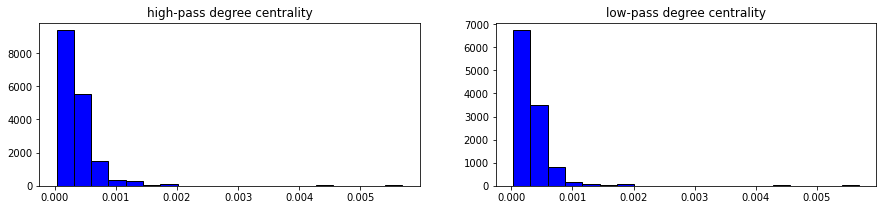

In [82]:
# compute all node's page rank
pr = nx.pagerank(G, alpha=0.9)

min_att = 1
plt.figure(figsize=(15,3))

print('Page Rank')
ax1 = plt.subplot(1, 2, 1)
ax1.set_title('high-pass degree centrality')
prs = torch.tensor([pr[n] for n in (high_attentions > min_att).nonzero(as_tuple=True)[1].tolist()])
print('high-pass  page rank mean: {}, std: {}'.format(prs.mean().item(), prs.std().item()))
plt.hist(prs, color = 'blue', edgecolor = 'black', bins = 20)

ax2 = plt.subplot(1, 2, 2)
ax2.set_title('low-pass degree centrality')
prs = torch.tensor([pr[n] for n in (low_attentions > min_att).nonzero(as_tuple=True)[1].tolist()])
print('low-pass page rank mean: {}, std: {}'.format(prs.mean().item(), prs.std().item()))
plt.hist(prs, color = 'blue', edgecolor = 'black', bins = 20);

Distance distribution of attended node

Attended node distance
high-pass node distance mean: 1.1961547136306763, std: 0.832538366317749
low-pass node distance mean: 0.7239596843719482, std: 0.7277522683143616


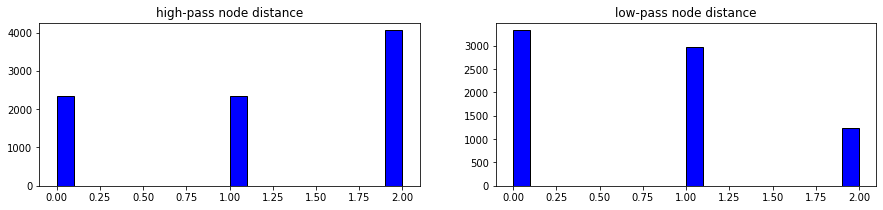

In [26]:
# Compute distances to from a node to its attended nodes
min_att = 2

high_distances = []

masked_high_attenions = high_attentions > min_att
for n1 in G.nodes:
    for n2 in G.nodes:
        if masked_high_attenions[n1, n2]:
            high_distances.append(nx.shortest_path_length(G, n1, n2))

low_distances = []

masked_low_attenions = low_attentions > min_att
for n1 in G.nodes:
    for n2 in G.nodes:
        if masked_low_attenions[n1, n2]:
            low_distances.append(nx.shortest_path_length(G, n1, n2))

            
plt.figure(figsize=(15,3))

print('Attended node distance')
ax1 = plt.subplot(1, 2, 1)
ax1.set_title('high-pass node distance')
distances = torch.tensor(high_distances).float()
print('high-pass node distance mean: {}, std: {}'.format(distances.mean().item(), distances.std().item()))
plt.hist(distances, color = 'blue', edgecolor = 'black', bins = 20)

ax2 = plt.subplot(1, 2, 2)
ax2.set_title('low-pass node distance')
distances = torch.tensor(low_distances).float()
print('low-pass node distance mean: {}, std: {}'.format(distances.mean().item(), distances.std().item()))
plt.hist(distances, color = 'blue', edgecolor = 'black', bins = 20);

Re-train model with cutoff

In [27]:
# Similar result as cutoff after training
# from citation import run
#
# model_cutoff = Net(dataset)
#
# max_cutoff=1
# cutoff_kernel = model_cutoff.analysis.filter_kernel
# model_cutoff.analysis.filter_kernel = CutOff(max_val=max_cutoff, kernel=cutoff_kernel)
# model_cutoff.analysis.filter._kernel = CutOff(max_val=max_cutoff, kernel=cutoff_kernel)
#
# plot_filter_banks(kernel=model_cutoff.analysis.filter_kernel)
# print(evaluate(model_cutoff, dataset[0]))
#
# run(dataset, model_cutoff, runs, epochs, lr, weight_decay, patience, None)
#
# plot_filter_banks(kernel=model_cutoff.analysis.filter_kernel)
# print(evaluate(model_cutoff, dataset[0]))


## Evaluate filterbanks

Define kernel to eliminate certain filterbanks

In [28]:
class Elimination(nn.Module):
    def __init__(self, zero_out_indices):
        super(Elimination, self).__init__()
        self.zero_out_indices = zero_out_indices

    def reset_parameters(self):
        pass

    def forward(self, x):
        x = filter_kernel(x)
        x[:, self.zero_out_indices] = torch.zeros(x.shape[0], len(self.zero_out_indices))
        return x

Evaluate each filter bank

In [29]:
all_indices = set(list(range(heads)))
for i in range(heads):
    zero_out_filters = list(all_indices.difference({i}))
    model.analysis.filter_kernel = Elimination(zero_out_filters)
    model.analysis.filter._kernel = Elimination(zero_out_filters)
    # plot_filter_banks(kernel=model.analysis.filter_kernel)
    print(evaluate(model, dataset[0]))

{'train_loss': 0.6465999484062195, 'train_acc': 0.80623973727422, 'val_loss': 0.7633665204048157, 'val_acc': 0.786, 'test_loss': 0.7658142447471619, 'test_acc': 0.777, 'f1_score': 0.7944093778178539}
{'train_loss': 0.632429301738739, 'train_acc': 0.8144499178981938, 'val_loss': 0.7580602765083313, 'val_acc': 0.786, 'test_loss': 0.7601093649864197, 'test_acc': 0.78, 'f1_score': 0.799819657348963}
{'train_loss': 0.6314824819564819, 'train_acc': 0.8160919540229885, 'val_loss': 0.7577400803565979, 'val_acc': 0.786, 'test_loss': 0.7597430348396301, 'test_acc': 0.779, 'f1_score': 0.8004207995190862}


KeyboardInterrupt: 

Evaluate by eliminating only one filter bank

In [ ]:
for i in range(heads):
    model.analysis.filter_kernel = Elimination([i])
    model.analysis.filter._kernel = Elimination([i])
    # plot_filter_banks(kernel=model.analysis.filter_kernel)
    print(evaluate(model, dataset[0]))


Load GAT model

In [104]:
from torch_geometric.nn import GATConv
class GAT(torch.nn.Module):
    def __init__(self, dataset):
        super(GAT, self).__init__()
        self.conv1 = GATConv(
            dataset.num_features,
            8,
            heads=8,
            dropout=0.6)
        self.conv2 = GATConv(
            64,
            dataset.num_classes,
            heads=1,
            concat=False,
            dropout=0.6)

    def reset_parameters(self):
        self.conv1.reset_parameters()
        self.conv2.reset_parameters()

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.dropout(x, p=0.6, training=self.training)
        x, (edge_index_1, att_val_1) = self.conv1(x, edge_index, return_attention_weights=True)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x, (edge_index_2, att_val_2) = self.conv2(x, edge_index, return_attention_weights=True)
        att1 = torch.zeros(data.num_nodes, data.num_nodes, 8)
        att2 = torch.zeros(data.num_nodes, data.num_nodes)
        att1[list(map(lambda x: torch.tensor(x), edge_index_1.tolist()))] = att_val_1
        att2[list(map(lambda x: torch.tensor(x), edge_index_2.tolist()))] = att_val_2.view(-1)
        return F.log_softmax(x, dim=1), att1, att2

gat = GAT(dataset)
gat.load_state_dict(torch.load('./model/best_{}_gat.pkl'.format(dataset_name)))
gat_correct_indices = get_correctly_predicted_node_idx(gat, 'test')

with torch.no_grad():
    _, gat_att1, gat_att2 = gat(dataset[0])
evaluate(gat, dataset[0])

{'train_loss': 0.8178199529647827,
 'train_acc': 0.8106185002736727,
 'val_loss': 0.8965532183647156,
 'val_acc': 0.81,
 'test_loss': 0.8940090537071228,
 'test_acc': 0.778,
 'f1_score': 0.8007213706041478}

In [105]:
np.sum([torch.prod(torch.tensor(p.shape)) for p in list(gat.parameters())])

237586

In [106]:
np.sum([torch.prod(torch.tensor(p.shape)) for p in list(model.parameters())])

325983

Comparison with GAT

In [107]:
model_correct_nodes = dataset[0]['test_mask'].nonzero().view(-1)[list(model_correct_indices)]
gat_correct_nodes = dataset[0]['test_mask'].nonzero().view(-1)[list(gat_correct_indices)]
model_not_gat_correct_nodes = dataset[0]['test_mask'].nonzero().view(-1)[list(model_correct_indices.difference(gat_correct_indices))]
model_and_gat_correct_nodes = dataset[0]['test_mask'].nonzero().view(-1)[list(model_correct_indices.intersection(gat_correct_indices))]
gat_not_model_correct_nodes = dataset[0]['test_mask'].nonzero().view(-1)[list(gat_correct_indices.difference(model_correct_indices))]
gat_and_model_incorrect_nodes = dataset[0]['test_mask'].nonzero().view(-1)[list(set(dataset[0].y[dataset[0]['test_mask']].nonzero().view(-1).tolist()).difference(model_correct_indices).difference(gat_correct_indices))]
print('Number of node classified correctly by our model:', len(model_correct_nodes))
print('Number of node classified correctly by GAT:', len(gat_correct_nodes))
print('Number of node classified correctly by our model but not by GAT:', len(model_not_gat_correct_nodes))
print('Number of node classified correctly by both GAT and our model:', len(model_and_gat_correct_nodes))
print('Number of node classified correctly by GAT but not by our model:', len(gat_not_model_correct_nodes))
print('Number of node classified incorrectly by GAT and our model:', len(gat_and_model_incorrect_nodes))


Number of node classified correctly by our model: 809
Number of node classified correctly by GAT: 778
Number of node classified correctly by our model but not by GAT: 54
Number of node classified correctly by both GAT and our model: 755
Number of node classified correctly by GAT but not by our model: 23
Number of node classified incorrectly by GAT and our model: 123


In [53]:
gat_att1_sum = gat_att1.sum(dim=2)

In [ ]:
node = model_not_gat_correct_nodes[1].item()
Gego = nx.ego_graph(G, node, 2)
nodePos = nx.layout.spring_layout(Gego)
plt.figure()
for n in Gego.nodes:
    nx.draw_networkx_nodes(Gego, nodePos,
                           nodelist=[n],
                           node_color=node_colors[dataset[0].y[n].item()],
                           node_shape="*" if n == node else "o",
                           node_size=300 if n == node else max(gat_att1_sum[node, n]*1e2, 5))
nx.draw_networkx_edges(Gego,nodePos, linewidths=0.5)


plt.figure()
for n in Gego.nodes:
    nx.draw_networkx_nodes(Gego, nodePos,
                           nodelist=[n],
                           node_color=node_colors[dataset[0].y[n].item()],
                           node_shape="*" if n == node else "o",
                           node_size=300 if n == node else max(model_att1_sum[node, n]*1e3, torch.tensor(0)).clamp_max(300))
nx.draw_networkx_edges(Gego,nodePos, linewidths=0.5)



Label distribution of nodes classified correctly by our model

In [ ]:
print('\nBetweeness centrality')
ax3 = plt.subplot(1, 1, 1)
# ax3.set_title('high-pass betweeness centrality')
centralities = torch.tensor([centrality_between[n] for n in (gat_att1_sum > min_att).nonzero(as_tuple=True)[1].tolist()])
print('high-pass centrality mean: {}, std: {}'.format(centralities.mean().item(), centralities.std().item()))
plt.hist(centralities, color = 'blue', edgecolor = 'black', bins = 20);

In [ ]:
print('\nBetweeness centrality')
ax3 = plt.subplot(1, 1, 1)
# ax3.set_title('high-pass betweeness centrality')
centralities = torch.tensor([centrality_between[n] for n in (model_att1_sum > min_att).nonzero(as_tuple=True)[1].tolist()])
print('high-pass centrality mean: {}, std: {}'.format(centralities.mean().item(), centralities.std().item()))
plt.hist(centralities, color = 'blue', edgecolor = 'black', bins = 20);

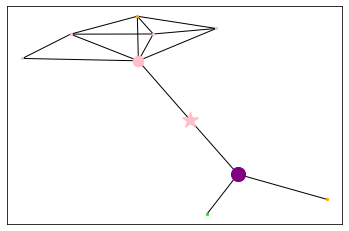

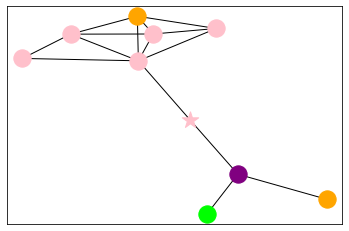

In [55]:
matching_labels_distribution(model_correct_nodes)

Label distribution of nodes classified correctly by our model


Betweeness centrality
high-pass centrality mean: 0.0003379184054210782, std: 0.001572551904246211


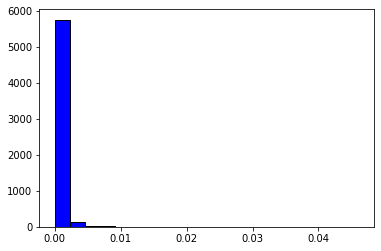

In [58]:
print('\nBetweeness centrality')
ax3 = plt.subplot(1, 1, 1)
# ax3.set_title('high-pass betweeness centrality')
centralities = torch.tensor([centrality_between[n] for n in (gat_att1_sum > min_att).nonzero(as_tuple=True)[1].tolist()])
print('high-pass centrality mean: {}, std: {}'.format(centralities.mean().item(), centralities.std().item()))
plt.hist(centralities, color = 'blue', edgecolor = 'black', bins = 20);


Betweeness centrality
high-pass centrality mean: 0.0011398987844586372, std: 0.004729916341602802


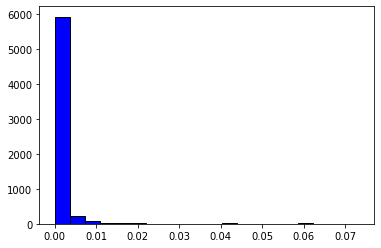

In [59]:
print('\nBetweeness centrality')
ax3 = plt.subplot(1, 1, 1)
# ax3.set_title('high-pass betweeness centrality')
centralities = torch.tensor([centrality_between[n] for n in (model_att1_sum > min_att).nonzero(as_tuple=True)[1].tolist()])
print('high-pass centrality mean: {}, std: {}'.format(centralities.mean().item(), centralities.std().item()))
plt.hist(centralities, color = 'blue', edgecolor = 'black', bins = 20);

In [56]:
matching_labels_distribution(model_correct_nodes)

KeyboardInterrupt: 

Label distribution of nodes classified correctly by GAT

In [ ]:
matching_labels_distribution(gat_correct_nodes)

Label distribution of nodes classified correctly by our model but not by GAT

In [ ]:
matching_labels_distribution(model_not_gat_correct_nodes)

Label distribution of nodes classified correctly our model and by GAT

In [ ]:
matching_labels_distribution(model_and_gat_correct_nodes)

Label distribution of nodes classified correctly GAT but not by our model

In [ ]:
matching_labels_distribution(gat_not_model_correct_nodes)

Label distribution of nodes classified incorrectly by both GAT and our model

In [ ]:
matching_labels_distribution(gat_and_model_incorrect_nodes)